/home/tanke/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


UMPM
step 1: elapsed 0.32242584228515625
step 2: elapsed 0.008464813232421875
step 3: elapsed 0.07674217224121094
step 4: elapsed 0.46889734268188477
-------------------------------------------
Handle transitivity:
	Intra:		 15
	Intra(choice):	 0
	Inter:		 80
	Inter(choice):	 93
-------------------------------------------
	Time =  197  ms
	result: 0

	Total cost: 27.11832844104704

# valid points:		 90
# invalid points:	 8
step 5: elapsed 0.20099616050720215
(smart candidate selection) [
	Time =  3  ms
	result: 0

	Total cost: 15.199807322171283
] (smart candidate selection)
step 6: elapsed 0.01900005340576172

total elapsed: 1.0973446369171143


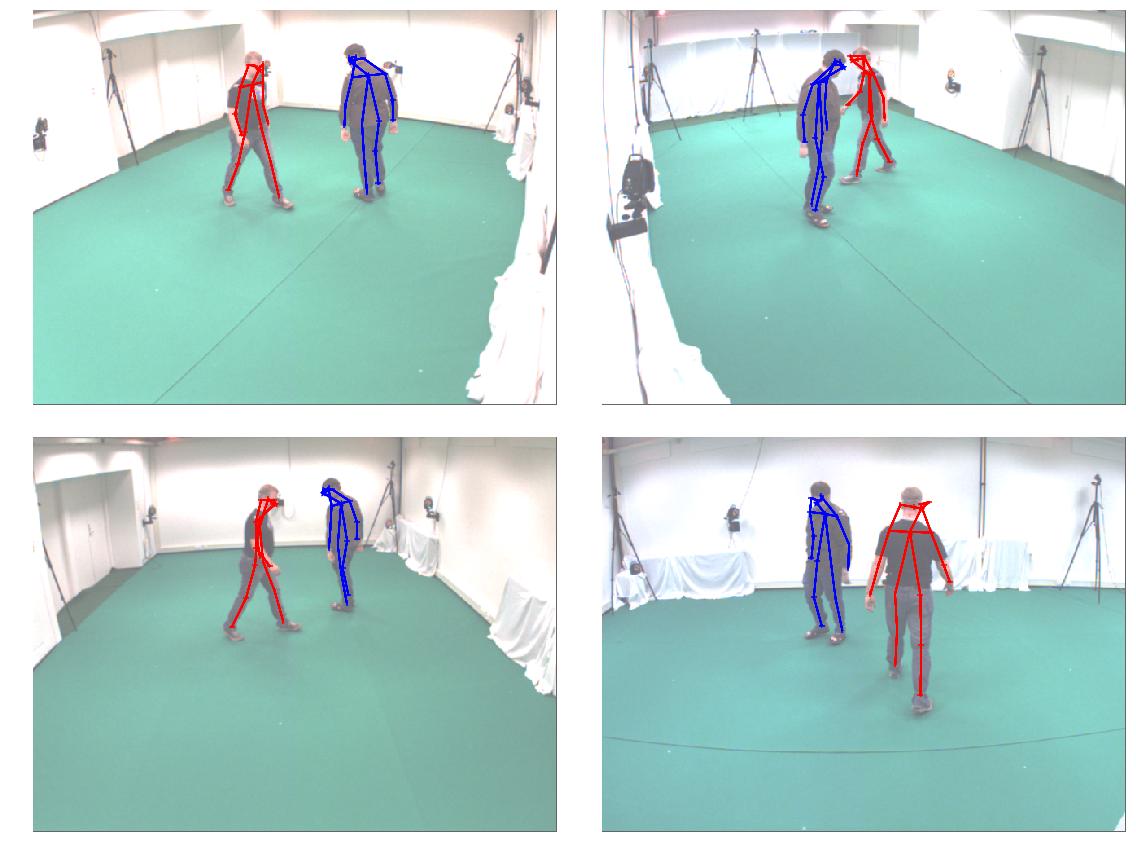

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '.')
import paf_loader
from os.path import join, isdir
import numpy as np
import cv2
from cselect import color as cs
from time import time
from mvpose import settings

from mvpose.data import umpm

params = settings.get_settings(ms_radius=30)
root = join(Settings['data_root'], 'pak')
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']
tmp = Settings['tmp']

FRAME = 1430

X, Y, Calib = umpm.get(root, 'p2_free_1', user, pwd)

Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])

heatmaps, pafs = paf_loader.load_confidence_map_and_paf('umpm', Im, 
                                                        FRAME, 
                                                        dir=tmp)

# ====================================
from mvpose import pose

_start = time()
Debug, detections = pose.estimate(
    Calib, heatmaps, pafs, settings=params, debug=True)
_end = time()
print('\ntotal elapsed:', _end - _start)
# ====================================

from mvpose.algorithm.candidate_selection import project_human_to_2d
from mvpose.plot.limbs import draw_mscoco_human

Humans = detections

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colors[pid])
    
plt.tight_layout()
plt.show()

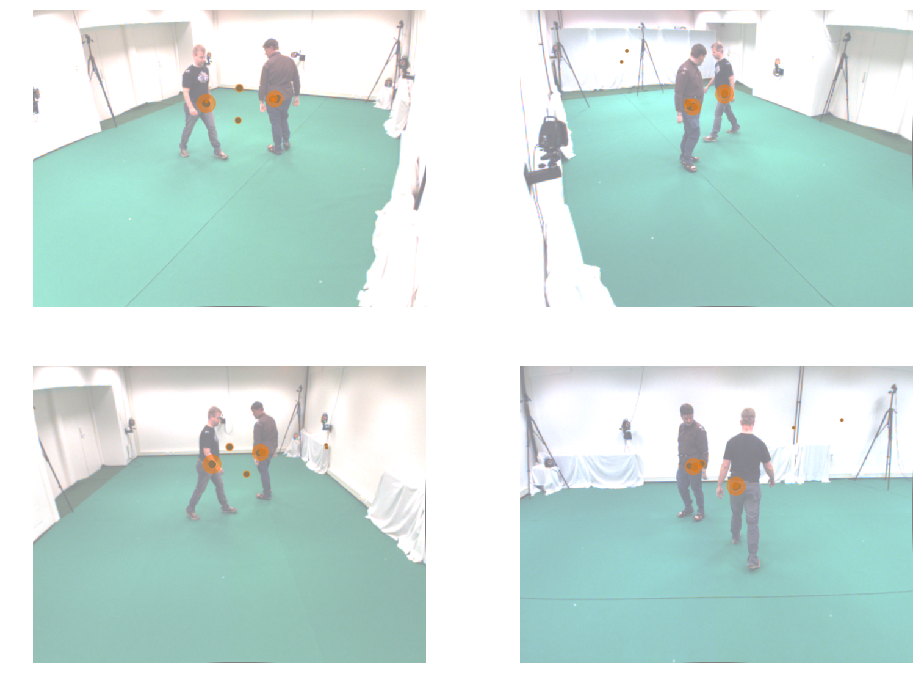

In [2]:
import mvpose.geometry.geometry as gm

JOINT = 11

pts3d_with_w = Debug.triangulation.peaks3d_weighted[JOINT]
pts3d = pts3d_with_w[:,0:3].astype('float32')


centers3d_with_w = Debug.meanshift.centers3d[JOINT]
centers3d = centers3d_with_w[:,0:3].astype('float32')


fig = plt.figure(figsize=(16,12))
for cid, (im, cam) in enumerate(zip(Im, Calib)):
    ax = fig.add_subplot(2, 2, cid+1)
    mapx = cam.mapx
    mapy = cam.mapy
    im = cv2.remap(im, mapx, mapy, interpolation=cv2.INTER_LINEAR)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    pts2d = cam.projectPoints_undist(pts3d)
    ax.scatter(pts2d[:,0], pts2d[:,1], 
               s=pts3d_with_w[:,3] * pts3d_with_w[:,4] * 50)
    
    centers2d = cam.projectPoints_undist(centers3d)
    ax.scatter(centers2d[:,0], centers2d[:,1], s=centers3d_with_w[:,3] * 50, alpha=0.5)
    
plt.show()

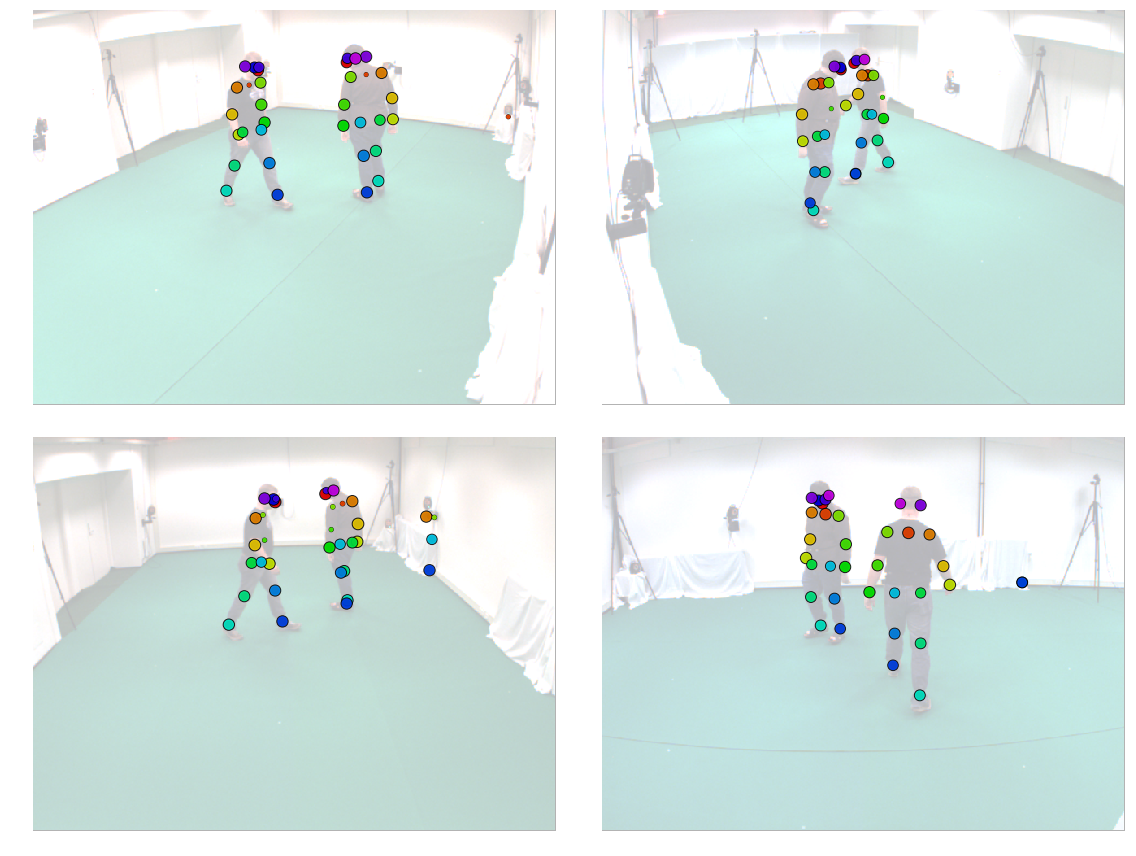

In [3]:
colors = cs.lincolor(22)/255

fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(2, 2, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.3)
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    cam = Calib[cid]
    
    for jid in range(Debug.candidates2d.n_joints):
        centers2d_with_w = Debug.candidates2d.peaks2d[cid][jid]
        if len(centers2d_with_w) == 0:
            continue
        centers2d = centers2d_with_w[:,0:2].astype('float32')
        score = centers2d_with_w[:,2]
        for p2d in centers2d:
            if p2d is not None:
                x, y = p2d
                ax.scatter(x, y, color='black', s=score*150, alpha=0.8)
                ax.scatter(x, y, color=colors[jid], s=score*100, alpha=0.8)
    
plt.tight_layout()
plt.show()

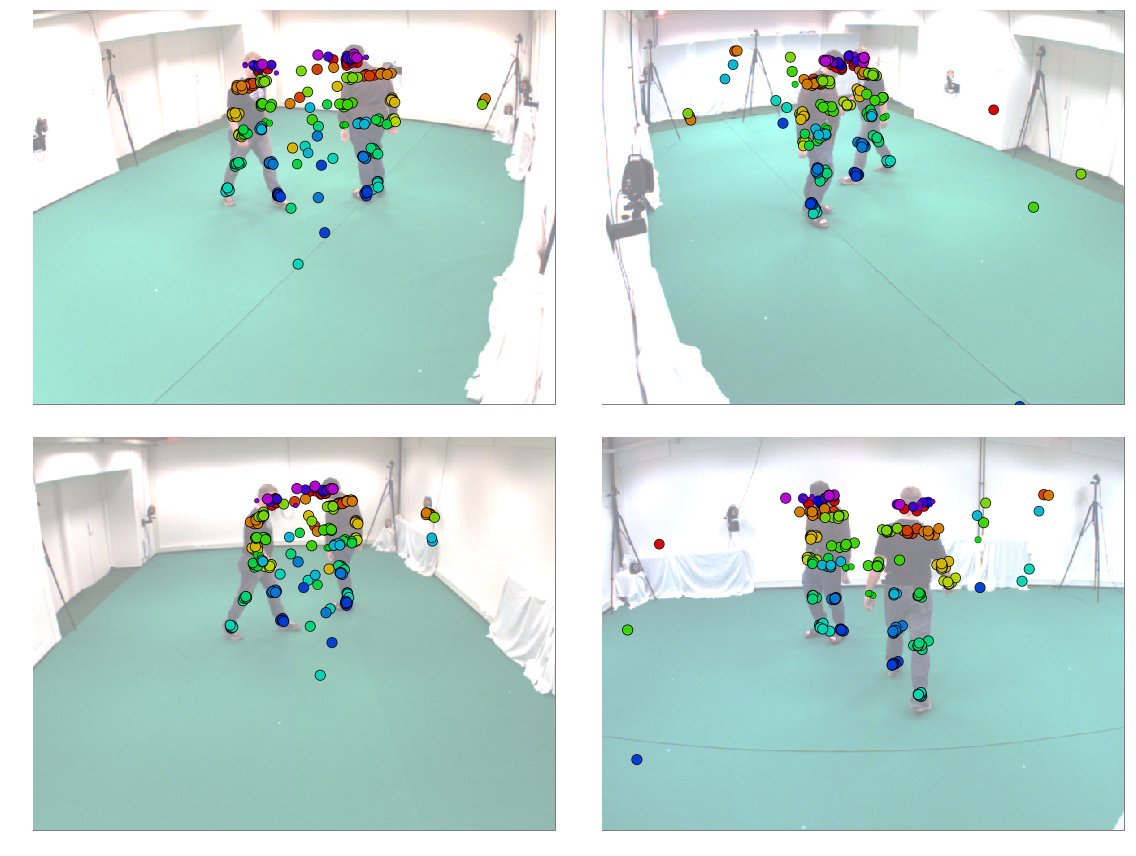

In [4]:
colors = cs.lincolor(22)/255

fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(2, 2, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    cam = Calib[cid]
    
    for jid in range(Debug.candidates2d.n_joints):
        centers3d_with_w = Debug.triangulation.peaks3d_weighted[jid]
        centers3d = centers3d_with_w[:,0:3].astype('float32')
        centers2d = cam.projectPoints(centers3d)
        score = centers3d_with_w[:,3]
        for p2d in centers2d:
            if p2d is not None:
                x, y = p2d
                ax.scatter(x, y, color='black', s=score*120, alpha=0.8)
                ax.scatter(x, y, color=colors[jid], s=score*80, alpha=0.8)

plt.tight_layout()
plt.show()

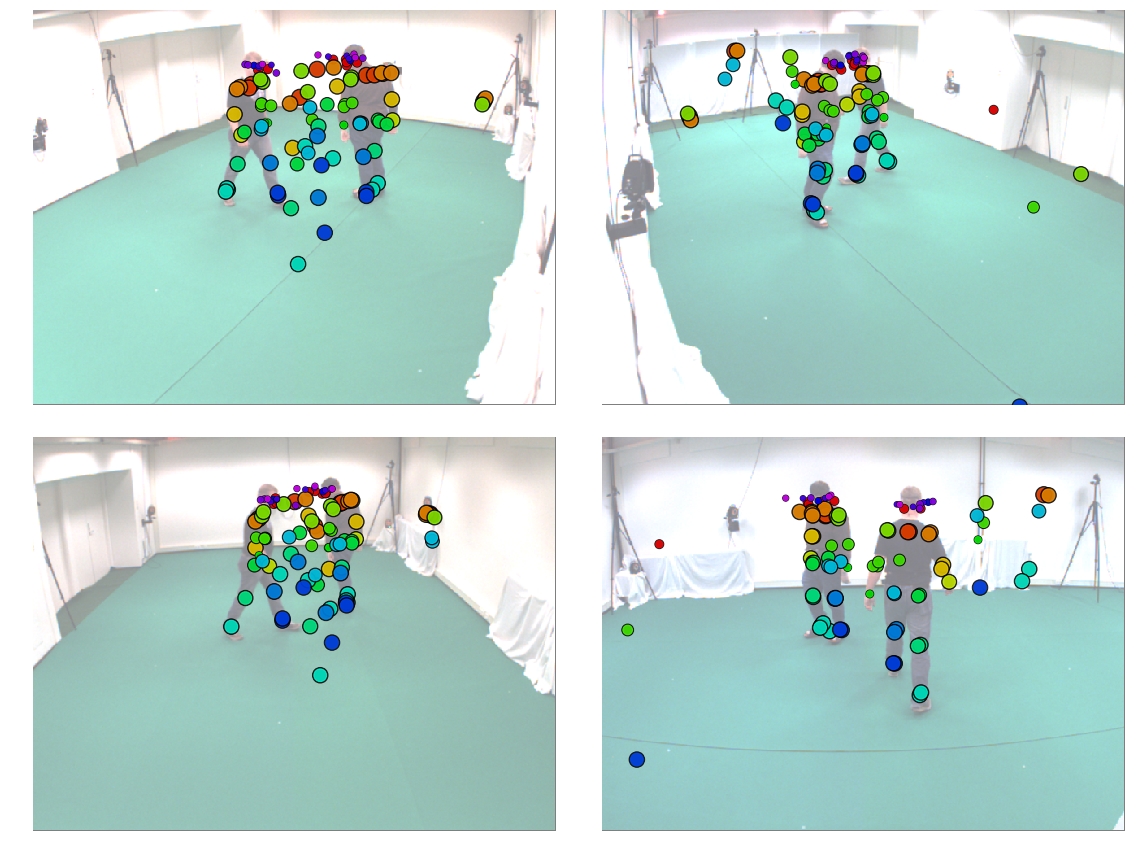

In [5]:
colors = cs.lincolor(22)/255

fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(2, 2, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    cam = Calib[cid]
    
    for jid in range(Debug.candidates2d.n_joints):
        centers3d_with_w = Debug.meanshift.centers3d[jid]
        centers3d = centers3d_with_w[:,0:3].astype('float32')
        centers2d = cam.projectPoints(centers3d)
        score = centers3d_with_w[:,3]
        for p2d in centers2d:
            if p2d is not None:
                x, y = p2d
                ax.scatter(x, y, color='black', s=score*120/4, alpha=0.8)
                ax.scatter(x, y, color=colors[jid], s=score*80/4, alpha=0.8)

plt.tight_layout()
plt.show()

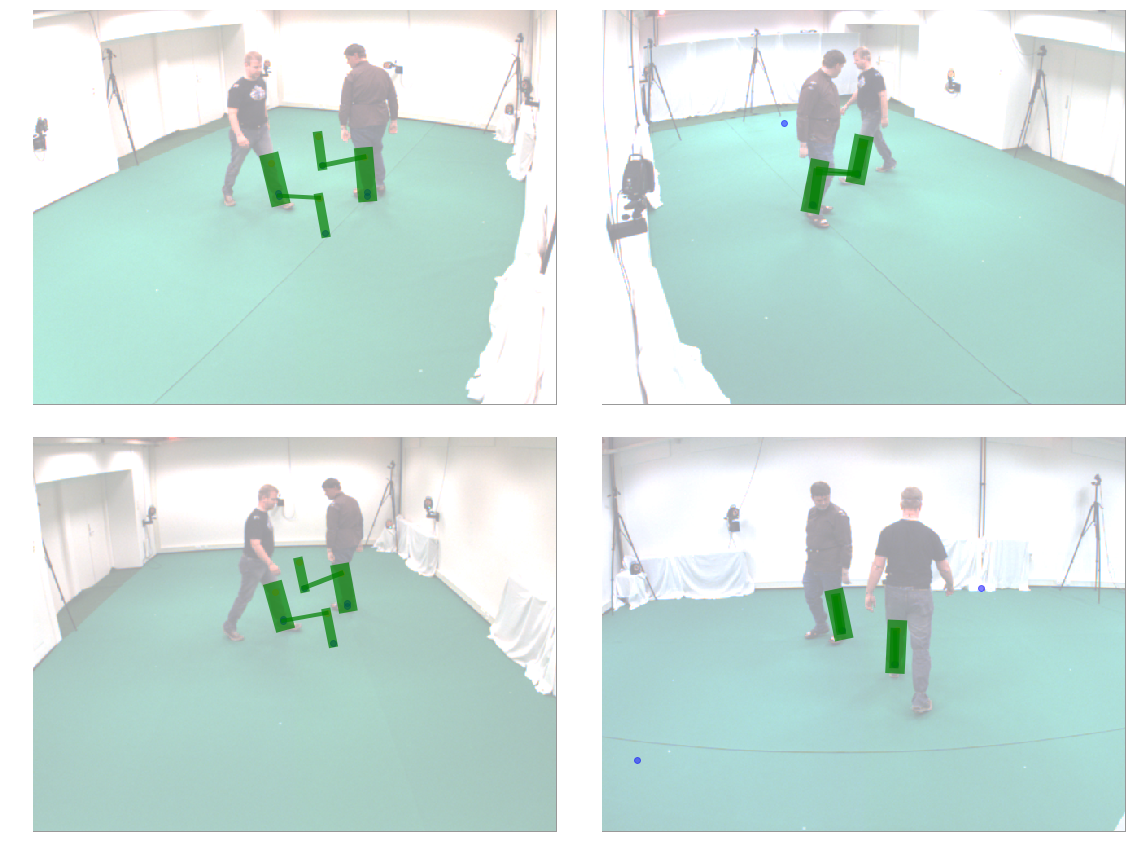

In [6]:
from mvpose.data.default_limbs import DEFAULT_LIMB_SEQ

LIMB_ID = 11
a,b = DEFAULT_LIMB_SEQ[LIMB_ID]

W = Debug.limbs3d[LIMB_ID]
n,m = W.shape

candA = Debug.meanshift.centers3d[a][:,0:3]
candB = Debug.meanshift.centers3d[b][:,0:3]
assert n == len(candA) and m == len(candB)

fig = plt.figure(figsize=(16,12))


for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    ptsA2d, maskA = cam.projectPoints(candA, withmask=True, binary_mask=False)
    ptsB2d, maskB = cam.projectPoints(candB, withmask=True, binary_mask=False)
    
    ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color='orange', alpha=0.5)
    ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color='blue', alpha=0.5)
    
    for _a in np.squeeze(maskA):
        for _b in np.squeeze(maskB):
            w = W[_a,_b]
            Ax,Ay = ptsA2d[_a]
            Bx,By = ptsB2d[_b]
            if w > 0:
                ax.plot([Ax,Bx], [Ay,By], color='green', linewidth=w*30, alpha=0.7)
            elif w > -99999:
                ax.plot([Ax,Bx], [Ay,By], color='red', linewidth=-w*30, alpha=0.7)

plt.tight_layout()
plt.show()

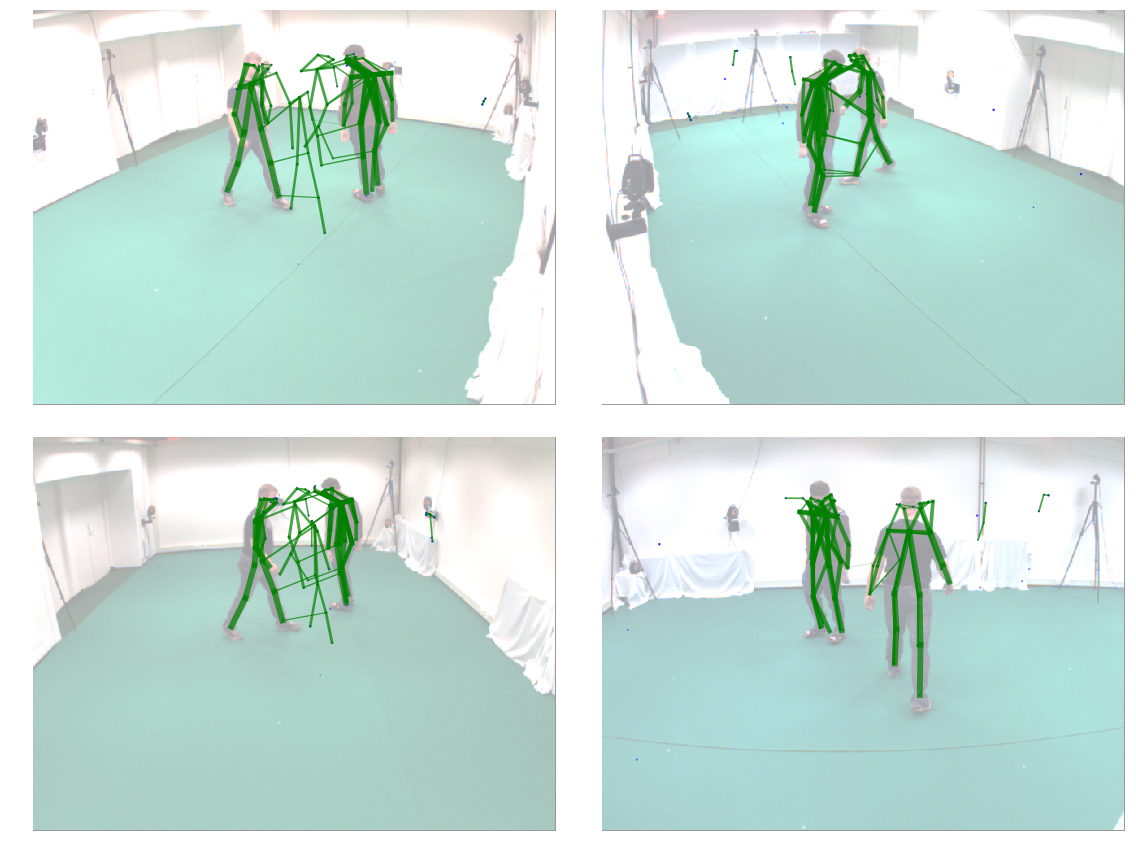

In [8]:
from mvpose.algorithm.graph_partitioning import get_unary

ALL_UNARIES = []
ALL_BINARIES = []
PBOOST_SMALL = lambda x: x

fig = plt.figure(figsize=(16,12))

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    for lid, (a, b) in enumerate(DEFAULT_LIMB_SEQ):
        candA = Debug.meanshift.centers3d[a][:,0:3]
        candB = Debug.meanshift.centers3d[b][:,0:3]
        W = Debug.limbs3d[lid]
        n, m = W.shape
        assert n == len(candA) and m == len(candB)
        
        ptsA2d, maskA = cam.projectPoints(candA, withmask=True, binary_mask=False)
        ptsB2d, maskB = cam.projectPoints(candB, withmask=True, binary_mask=False)
        unaryA = get_unary(Debug.triangulation.peaks3d_weighted[a])[maskA]
        #unaryA = unaryA/np.max(unaryA)
        unaryA = PBOOST_SMALL(np.clip(unaryA, a_min=0.00000001, a_max=0.99999999))
        unaryB = get_unary(Debug.triangulation.peaks3d_weighted[b])[maskB]
        #unaryB = unaryB/np.max(unaryB)
        
        unaryB = PBOOST_SMALL(np.clip(unaryB, 
                                      a_min=-0.99999999, 
                                      a_max=0.99999999))
        
        ALL_UNARIES.extend(unaryA)
        ALL_BINARIES.extend(unaryB)
        
        colorA = ['blue' if q > 0 else 'red' for q in unaryA]
        colorB = ['blue' if q > 0 else 'red' for q in unaryB]
        
        ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color=colorA, alpha=0.3, s=np.abs(unaryA) * 2)
        ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color=colorB, alpha=0.3, s=np.abs(unaryB) * 2)
        
        for _a in range(len(ptsA2d)):
            for _b in range(len(ptsB2d)):
                w = W[_a,_b]
                Ax,Ay = ptsA2d[_a]
                Bx,By = ptsB2d[_b]
                if w > 0:
                    ax.plot([Ax,Bx], [Ay,By], color='green', linewidth=w*9, alpha=0.7)
                elif w > -99999:
                    ax.plot([Ax,Bx], [Ay,By], color='red', linewidth=-w*9, alpha=0.7)

plt.tight_layout()
plt.show()